# Creating your own datasets on your private server

In addition to querying existing datasets, the QCArchive software can be used to easily generate new ones. In this example, we will create a new dataset of small molecules with up to 3 heavy atoms and compute their DFT and AN1-1x energies. 

For this example, we will use a demonstation "Snowflake" server which runs calculations locally in this Jupyter notebook session. In general, QCArchive can be used with thousands of distributed compute nodes at once. 

In [2]:
import numpy as np
import pandas as pd
import qcportal as ptl

from qcfractal import FractalSnowflakeHandler

server = FractalSnowflakeHandler()
local_client = server.client()

Our new dataset will be called "QM3":

In [3]:
qm3 = ptl.collections.Dataset(name="QM3", client=local_client, default_units="hartree")

### Adding molecules to a dataset

The following function counts heavy atoms in a molecule:

In [4]:
def count_heavy_atoms(molecule):
    return len(list(filter(lambda a: a != 'H', molecule.symbols)))

The `add_entry` function adds a molecule to a dataset. Below, we add all molecules in QM7b with 3 or fewer heavy atoms. The `save` function commits these changes to the server. First, pull QM7b down from the MolSSI server:

In [5]:
client = ptl.FractalClient()
qm7b = client.get_collection("dataset", "QM7b")
qm7b_mols = qm7b.get_molecules()

In [6]:
for molecule in qm7b_mols["molecule"]:
    if count_heavy_atoms(molecule) <= 3:
        qm3.add_entry(f"{molecule.name}_{molecule.get_hash()[:2]}", molecule)
qm3.save()

'1'

We can now query the server for the molecules in our dataset:

In [7]:
qm3.get_molecules()

,molecule
index,
CH4_b3,"Geometry (in Angstrom), charge = 0.0, mult..."
C2H6_f3,"Geometry (in Angstrom), charge = 0.0, mult..."
C2H3N_a0,"Geometry (in Angstrom), charge = 0.0, mult..."
C2H7N_57,"Geometry (in Angstrom), charge = 0.0, mult..."
C2H4O_07,"Geometry (in Angstrom), charge = 0.0, mult..."
C2H6O_18,"Geometry (in Angstrom), charge = 0.0, mult..."
C2H4O_15,"Geometry (in Angstrom), charge = 0.0, mult..."
C2H6O_69,"Geometry (in Angstrom), charge = 0.0, mult..."
C2H4_96,"Geometry (in Angstrom), charge = 0.0, mult..."


And look at one of them:

In [8]:
qm3.get_molecules(subset="C2H6O_18")

_ColormakerRegistry()

NGLWidget()

### Running calculations

Our QM3 dataset now has all of its molecules, but no properties have been computed for them.

In [9]:
qm3.list_values()

,,,,,keywords,name
native,driver,program,method,basis,,


----

<img src="https://raw.githubusercontent.com/psi4/psi4media/master/logos-psi4/psi4square.png" alt="psi4" align="left" style="width: 80px;"/>
<img src="https://raw.githubusercontent.com/aiqm/torchani/master/logo1.png" alt="torchani" align="right" style="width: 120px;"/>

The `compute` function is used to submit calculations for every molecule in a dataset. 
We will compute the ωB97x/6-31g(d) energy for each molecule using the Psi4 program, and the ANI-1x energy using the TorchANI program. (Other supported programs include CFOUR, entos, GAMESS, Q-Chem, Molpro, MOPAC, NWChem, RDKit, TeraChem, and Turbomole.)

In [10]:
qm3.compute(program='psi4', method='wB97x', basis='6-31g(d)')

<ComputeResponse(nsubmitted=16 nexisting=0)>

In [11]:
qm3.compute(program="torchani", method="ANI1x")

<ComputeResponse(nsubmitted=16 nexisting=0)>

The calculations are submitted and run asynchronously.

As before, values are described with `list_values` and queried with `get_values`. Incomplete calculations show up as `NaN`, pandas placeholder for missing data.

In [12]:
qm3.list_values()

keywords                 name
native driver program  method basis                                 
True   energy psi4     wb97x  6-31g(d)     None  WB97X/6-31g(d)-Psi4
              torchani ani1x  None         None       ANI1X-Torchani

In [16]:
dft_data = qm3.get_values(program='psi4')
dft_data

,WB97X/6-31g(d)-Psi4
CH4_b3,-40.4996
C2H6_f3,-79.8015
C2H3N_a0,-132.714
C2H7N_57,-135.122
C2H4O_07,-153.746
C2H6O_18,-154.99
C2H4O_15,-153.786
C2H6O_69,-154.979
C2H4_96,-78.5573
C2H2_66,-77.2971


In [17]:
ml_model_data = qm3.get_values(program='torchani')
ml_model_data

,ANI1X-Torchani
CH4_b3,-40.4997
C2H6_f3,-79.8012
C2H3N_a0,-132.714
C2H7N_57,-135.122
C2H4O_07,-153.746
C2H6O_18,-154.99
C2H4O_15,-153.786
C2H6O_69,-154.978
C2H4_96,-78.5572
C2H2_66,-77.2973


We can compare the ANI-1x predictions to the DFT values:

In [18]:
import plotly.express as px

data = pd.merge(dft_data, ml_model_data, left_index=True, right_index=True)

data["Unsigned Difference (Hartree)"] = np.abs(data["WB97X/6-31g(d)-Psi4"] - data["ANI1X-Torchani"])

fig = px.violin(data, y="Unsigned Difference (Hartree)", box=True, 
               title="Difference Distribution between ANI-1x and ωB97x/6-31g(d)")
fig.show()

## Other calculations you can do

- `Dataset`: Single point, gradients, and freqencies
- `ReactionDataset`: Reactions and interaction energies, with many-body counterpoise corrections
- `OptimizationDataset`: Geometry optimization
- `TorsionDriveDataset`: PES scans over torsion angles, for force field fitting.

Talk to us about adding more!

- (AI)MD trajectories?
- Normal mode sampling?

## The QCArchive stack enables large-scale, multi-resource calculations
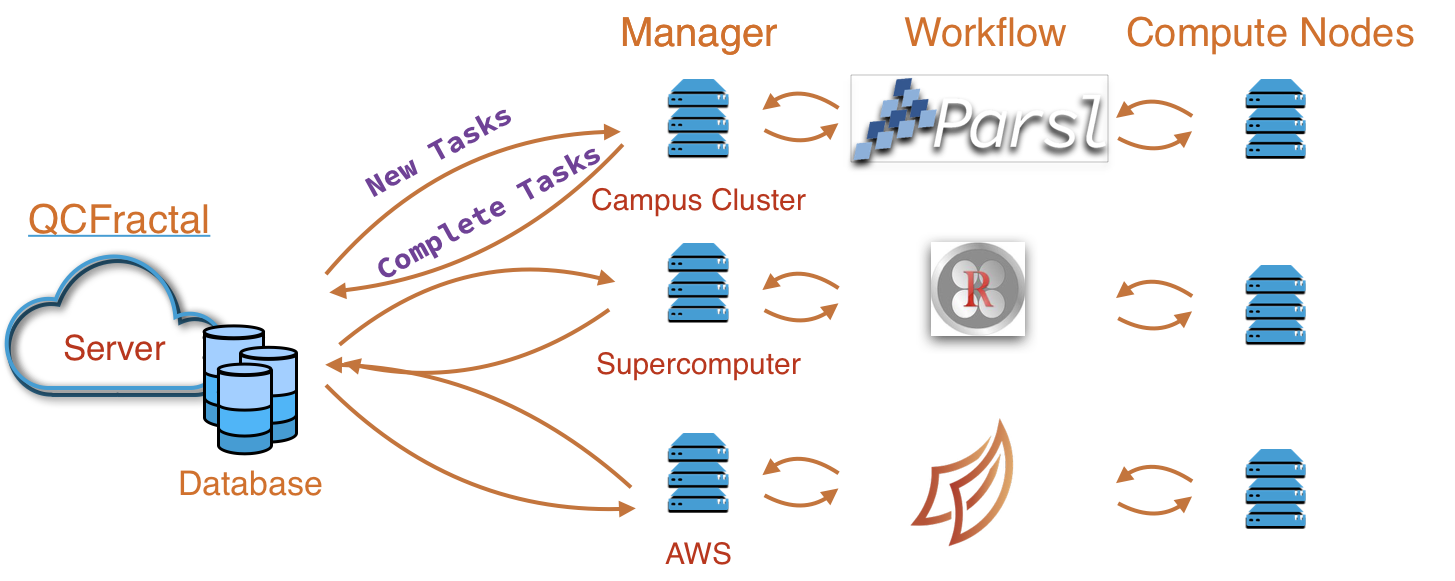

## Ongoing data enrichment efforts

With the QCArchive framework, it is very easy to submit new calculations on existing datasets. In the MolSSI database, we are augmenting existing datasets with a common set of calculations at various levels of DFT:

- HF / Def2-TZVP
- LDA / Def2-TZVP
- PBE-D3M(BJ) / Def2-TZVP
- B3LYP-D3M(BJ) / Def2-TZVP
- ωB97x-D3(BJ) / Def2-TZVP

and, where feasible:

- MP2 / cc-pVTZ
- CCSD(T) / cc-pVTZ

Let us know if there are properties/calculations that you would like!

# Extras

In [ ]:
from IPython.core.display import HTML

def print_info(dataset):
    print(f"Name: {dataset.data.name}")
    print()
    print(f"Data Points: {dataset.data.metadata['data_points']}")
    print(f"Elements: {dataset.data.metadata['elements']}")
    print(f"Labels: {dataset.data.metadata['labels']}")
    
    display(HTML("<u>Description:</u> " + dataset.data.description))
    
    for cite in dataset.data.metadata["citations"]:
        display(HTML(cite['acs_citation']))